In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import seaborn as sns

from ipywidgets import interact 


%matplotlib inline
# %matplotlib notebook

# Image Analysis

The purpose of this notebook is to learn how to further access 3D image stack data in the jupyter notebook/python space, and to implement image analysis on the provided 2D photo. Since this notebook is a continuation of the previous introductory exploration of the MorphoSource database, I will be using the same Fish data for this notebook as well. 

****Note/Citation**: The following image analysis will be based off of Jonas Harmann's bioimage analysis, which can be found [here](https://github.com/WhoIsJack/python-bioimage-analysis-tutorial/blob/master/image_analysis_tutorial_solutions.ipynb).

In [2]:
filename = r"Info.jpg"
dirpath = r"/Users/samanthatang/Desktop/URAP/Morphosource_no_specimen_M16076/no_specimen_M16076-29919_no_specimen"

In [3]:
from os.path import join

#combining file name and directory path into one variable
filepath = join(dirpath, filename)
print(filepath) #good practice to always print out to double check

/Users/samanthatang/Desktop/URAP/Morphosource_no_specimen_M16076/no_specimen_M16076-29919_no_specimen/Info.jpg


In [4]:
from skimage.io import imread
img = imread(filepath)
img;

In [5]:
#checking the images 

print("Loaded array is of type: ", type(img))

print("Loaded array has shape: ", img.shape)

print("Loaded values are of type: ", img.dtype)

Loaded array is of type:  <class 'numpy.ndarray'>
Loaded array has shape:  (387, 768, 3)
Loaded values are of type:  uint8


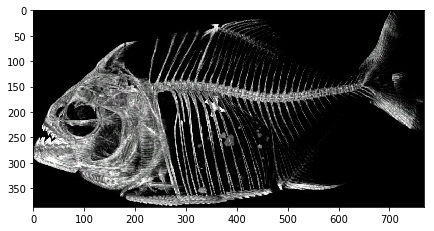

In [6]:
#looking/displaying the image
plt.figure(figsize=(7,7))
plt.imshow(img, interpolation="none", cmap="gray")
plt.show()

As shown above, this is the 2D image from the provided stack scans downloaded from MorphoSource, specifically, the info.jpg which illustrates a 2D demonstration of what the 3D stack scans will create. 

**NOTE**: The following image analysis techniques may not be necessary for this specific image (i.e. separating object and background, since its already rather clear what the object and background is in this image), but it's good practice, and a learning experience just to explore/play with these techniques.

# Preprocessing

To begin analyzing the data, we will want to segment or divide the image into regions or pixels, and to do this, we will be thresholding the image. In other words, if we look at a image histogram, which documents the tonal distribution of an image (i.e. plots the number of pixels for each tone/color value), a threshold value will separate the object in the picture from its background$^{1}$ (see the cited page for histogram visualization and more elaborate explanation).

But first we must smooth the image so that we can get a image histogram where we can easily identify the threshold value.

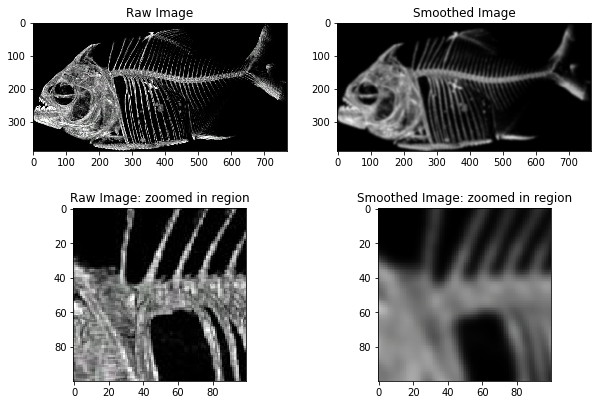

In [7]:
#Gaussian smoothing: 

#Note: the larger the sigma value, the smoother/more blurred the image will be

sigma = 3
img_smooth = ndi.filters.gaussian_filter(img, sigma) #smooth image

fig, ax = plt.subplots(2, 2, figsize=(10, 7))
ax[0,0].imshow(img, interpolation="none", cmap="gray")
ax[0,1].imshow(img_smooth, interpolation="none", cmap="gray")

ax[1,0].imshow(img[100:200, 200:300], interpolation="none", cmap="gray") #zoom into section
ax[1,1].imshow(img_smooth[100:200, 200:300], interpolation="none", cmap="gray") #zoom into section


ax[0,0].set_title("Raw Image")
ax[0,1].set_title("Smoothed Image")
ax[1,0].set_title("Raw Image: zoomed in region")
ax[1,1].set_title("Smoothed Image: zoomed in region")

plt.show()


#Histograms of the image#

Referencing the first cited website in "References", I've created an image histogram to show the results of our smoothing/thresholding on the image. The image histogram is supposed to show us the threshold value with which we should choose to separate our object image from our background image (see below). 

![image](images/morpho2_images/image_hist.png)


Since our original image is already pretty clear/separate from its background, further blurring/smoothing will only make the image harder to separate from its background. And as shown below, as the sigma value increases (aka more smoothing), the harder it is to distinguish a threshold point from the image histogram (orange).

In [8]:

# plt.subplot(121).hist(img.ravel(), 10) #.ravel flattens 3d array into 1d to plot histogram
# plt.title("Original")

# plt.subplot(122).hist(img_smooth.ravel(), 10)
# plt.title("Smoothed")
# plt.tight_layout()



@interact(sig=(1, 255))
def change_sigma(sig=5):    
    
    img_smooth = ndi.filters.gaussian_filter(img, sig) #smooth image
    
    sns.distplot(img.ravel(), bins=20, kde=True) #.ravel flattens 3d array into 1d to plot histogram
    sns.distplot(img_smooth.ravel(), bins=20, kde=True)
    
    plt.title("Image Histogram of Original and Smoothed Image")
    plt.legend(["Original", "Smooth"])



interactive(children=(IntSlider(value=5, description='sig', max=255, min=1), Output()), _dom_classes=('widget-…

# Manual Thresholding

Now, that we have a smoothed image, or at least an image that is differentiable from its background, we can perform thresholding to actually separate the background image from the object image. We can do this by manually providing a threshold number and a threshold type: 

Note: Originally I was going to follow the bio-image tutorial, but it seemed that using skimage didn't work for me, so I opted for using opencv. The following are based off of the opencv documentation about thresholding and googled tutorials $^{2, 3}$ (see citations below--very helpful).

Parameters in cv2.threshold(): see [documentation](https://docs.opencv.org/2.4/doc/tutorials/imgproc/threshold/threshold.html)

1. image
2. threshold value
3. max value
4. threshold type: 
    - THRESH_BINARY: "either or" threshold, sets the pixel to max value if higher than threshold value, and 0 otherwise
    - THRESH_BINARAY_INV: "either or, but flipped", sets pixel to 0 if higher than threshold value, and max value otherwise
    - THRESH_TRUNC: the max intensity for each pixel is the threshold value, and when the intensity value of the pixel for the source image is greater than the threshold value, then it is "truncated"
    - THRESH_TOZERO: when the intensity value of the pixel for the source image is less than the threshold value, then the pixel is set to 0
    - THRESH_TOZERO_INV: opposite of tozero, when intensity of pixel is greater than threshold value, then new pixel is 0

Text(0.5, 1.0, 'Thresholded: smoothed')

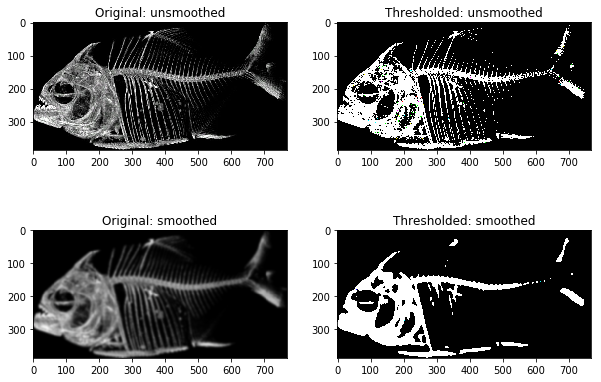

In [9]:
#opencv thresholding: 

import cv2


ret1, thres1 = cv2.threshold(img, 100, 255, cv2.THRESH_BINARY)
ret2, thres2 = cv2.threshold(img_smooth, 100, 255, cv2.THRESH_BINARY)

fig, ax = plt.subplots(2, 2, figsize=(10, 7))
ax[0,0].imshow(img, interpolation="none", cmap="gray")
ax[0,1].imshow(thres1, interpolation="none", cmap="gray")

ax[0,0].set_title("Original: unsmoothed")
ax[0,1].set_title("Thresholded: unsmoothed")

#-----------------------------------------------

ax[1,0].imshow(img_smooth, interpolation="none", cmap="gray")
ax[1,1].imshow(thres2, interpolation="none", cmap="gray")

ax[1,0].set_title("Original: smoothed")
ax[1,1].set_title("Thresholded: smoothed")





In [10]:
#attempting to create interactive widget (similar to the bio-image tutorial, but with opencv)


@interact(thres=(1, 255))
def interative(thres=100):
    ret1, t1 = cv2.threshold(img_smooth, thres, 255, cv2.THRESH_BINARY)
    ret2, t2 = cv2.threshold(img_smooth, thres, 255, cv2.THRESH_BINARY_INV)
    ret3, t3 = cv2.threshold(img_smooth, thres, 255, cv2.THRESH_TRUNC)
    ret4, t4 = cv2.threshold(img_smooth, thres, 255, cv2.THRESH_TOZERO)
    ret5, t5 = cv2.threshold(img_smooth, thres, 255, cv2.THRESH_TOZERO_INV)
    
    index = 0
    titles = ["Binary", "Binary_Inv", "Trunc", "ToZero", "ToZero_Inv"]
    img_thresholds = [t1, t2, t3, t4, t5]
    
    plt.figure(figsize=(10, 7))
    
    for i in np.arange(1, 6):
        plt.subplot(3, 2, i).imshow(img_thresholds[index], interpolation="none", cmap="gray")
        plt.title(titles[index])
        index += 1
    
    plt.tight_layout()

interactive(children=(IntSlider(value=100, description='thres', max=255, min=1), Output()), _dom_classes=('wid…

# Adaptative Thresholding

The below is a form of adaptive thresholding using Otsu's algorithm, which will automatically calculate a threshold value from the image histogram. However, this works best if the image histogram is bimodel, meaning there are two peaks, and as we've seen before, the histogram for this image only has one peak so the resulting image/binarization should not be very accurate.

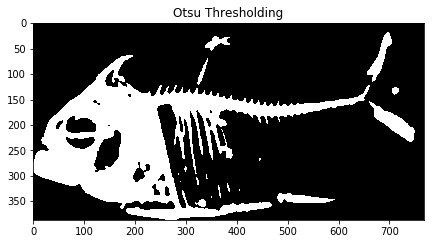

In [11]:
#performing Otsu's algorithm threshold (automated thresholds)
#can do this in opencv and skimage (see tutorial for skimage)

#NOTE: the below code ONLY work if image is in GRAYSCALE, so convert first

gray_scale_img_smooth = cv2.cvtColor(img_smooth, cv2.COLOR_BGR2GRAY)

otsu_ret, otsu_thresh = cv2.threshold(gray_scale_img_smooth, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) 

plt.figure(figsize=(7,7))
plt.imshow(otsu_thresh, interpolation='none', cmap='gray')
plt.title("Otsu Thresholding")
plt.show()

We can also do adaptive gaussian threshold and adaptive mean threshold as shown in the following two cells. If you take a look at the site where the below code was adapted from, there are some really interesting uses for how to use image segmentation and thresholding to clean up badly taken photos (so that it'll be more clear to read/see).

But basically, the point of using either gaussian thresholds or adaptive mean threshold algorithms to calculate threshold values is because, in some cases (like if there are different lighting conditions for different parts of the image), it may be better to threshold a pixel based on the region around it. Thus, we have different thresholds for different regions of the image, and may give better results, if say, there are different lightings in different parts of the image. 

Taken from the [opencv documentation](https://docs.opencv.org/3.4/d7/d4d/tutorial_py_thresholding.html), the following are brief descriptions on the respective algorithms used: 

1. cv.ADAPTIVE_THRESH_MEAN_C: The threshold value is the mean of the neighbourhood area minus the constant C.
2. cv.ADAPTIVE_THRESH_GAUSSIAN_C: The threshold value is a gaussian-weighted sum of the neighbourhood values minus the constant C.

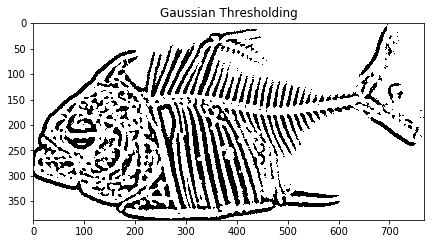

In [12]:
##adapted from https://pythonprogramming.net/thresholding-image-analysis-python-opencv-tutorial/
adapt_t = cv2.adaptiveThreshold(gray_scale_img_smooth, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

plt.figure(figsize=(7,7))
plt.imshow(adapt_t, interpolation='none', cmap='gray')
plt.title("Gaussian Thresholding")
plt.show()

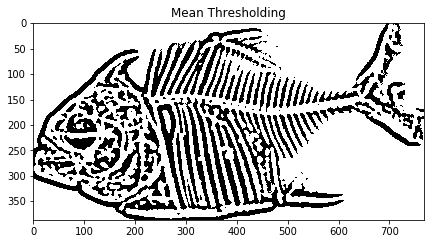

In [13]:
adapt_t2 = cv2.adaptiveThreshold(gray_scale_img_smooth, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

plt.figure(figsize=(7,7))
plt.imshow(adapt_t2, interpolation='none', cmap='gray')
plt.title("Mean Thresholding")
plt.show()

# Stacks: 2D Movie!

Below is an attempt to recreate the stack scan video as shown when using Fiji. Note: It may take a few minutes to load the movie because of the immense size of the file/scans.

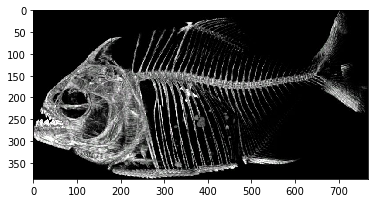

In [14]:
img.shape #(387, 768, 3)

len(img) #387 length of entire img array
len(img[0]) #768 length of each inner array
img[0][0] #3 length/columns 

plt.imshow(img)

In [20]:
import matplotlib.animation as animation

In [21]:
stack_file = r"Stack"
s_dirpath = r"/Users/samanthatang/Desktop/URAP/Morphosource_no_specimen_M16076/no_specimen_M16076-29919_no_specimen"

In [22]:
s_filepath = join(s_dirpath, stack_file)
print(s_filepath) #print out to double check

/Users/samanthatang/Desktop/URAP/Morphosource_no_specimen_M16076/no_specimen_M16076-29919_no_specimen/Stack


In [23]:
# Credits to for code on how to read files: 
# https://stackoverflow.com/questions/33369832/read-multiple-images-on-a-folder-in-opencv-python/43049639

from os import listdir
from os.path import isfile, join
import numpy
import cv2

mypath=s_filepath
onlyfiles = [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]
images = numpy.empty(len(onlyfiles), dtype=object)
for n in range(0, len(onlyfiles)):
  images[n] = cv2.imread( join(mypath,onlyfiles[n]) )

# images.shape

Now that we have read all the files into an "images" variable, we can finally display the 2D stack movie using the code below (you can see the "Movies" section of references to get a better understanding of how the animation.FuncAnimation method works). Note: This cell block will mostly likely take a long time depending on how large your stack image file is. Also, you may have to install mencode, ffmpeg, or something similar for the video to display.

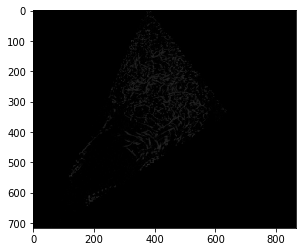

In [24]:
from IPython.display import HTML

#create figure window
fig, ax = plt.subplots()
im = ax.imshow(images[0]) #create image object which will be modified in animation


def animate(frames):
    im.set_array(images[frames])
    return im,


#blit = overdraws
movie = animation.FuncAnimation(fig, animate, interval=20, frames=images.shape[0], blit=True)

# movie.save('movie.gif', writer='mencoder') #can use this to save to desktop
HTML(movie.to_html5_video()) #will probably take a SUPER long time, but it should work to create movie

# **References/Citations:**

The links/websites below are referenced or cited resources that were very useful in understanding and in implementing the image analysis and 2D movie creation performed above. 

**Thresholding**: 

1. $^{1}$http://cs.haifa.ac.il/hagit/courses/ip/Lectures/Ip12_Segmentation.pdf is very useful for understanding Thresholding and how images are segmented, following the bio_image analysis tutorial

2. $^{2}$https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html (opencv documentation/exmaples on thresholding)

3. $^{3}$https://pythonprogramming.net/thresholding-image-analysis-python-opencv-tutorial/ (example walkthough and great explanation of thresholding to clear image so that it'll be readable)

4. further reading: http://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/MORSE/threshold.pdf


**Movie**: 

1. http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/

2. https://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/

3. https://riptutorial.com/matplotlib/example/23558/basic-animation-with-funcanimation (basic skeleton from here)

4. https://www.numfys.net/howto/animations/ (very useful on how to display images, also tells you how you can save the video as a mp4 or gif on local computer using ipython display code (see link))

5. https://stackoverflow.com/questions/13316397/matplotlib-animation-no-moviewriters-available/14574894#14574894
had to install conda install -c menpo ffmpeg and/or mencoder to save animation : conda install -c conda-forge ffmpeg